In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pandas as pd
from seminartools.models.four_quarter_average_model import FourQuarterAverageModel
from seminartools.data import read_merged
from seminartools.data import read_inflation

# 1. Read data

In [33]:
df = read_merged().reset_index()
df

c:\users\vandi\onedrive\documenten\github\seminar\seminartools\data.py:161: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample("Q").apply(lambda x: (1 + x).prod() - 1)  # quarterly return
c:\users\vandi\onedrive\documenten\github\seminar\seminartools\data.py:397: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample("Q").mean()  # Mean interest rate


,country,date,inflation,gdp_growth,interest_rate,unemployment_rate,commodity_CRUDE_PETRO,commodity_iNATGAS,commodity_iAGRICULTURE,commodity_iMETMIN,commodity_iPRECIOUSMET
0,Japan,1977-01-01,0.022951,2.187257,6.333333,2.3,0.00000,0.052425,0.144757,0.041940,0.112740
1,Canada,1977-01-01,0.023904,1.533830,8.166667,8.8,0.00000,0.052425,0.144757,0.041940,0.112740
2,United States,1977-01-01,0.017231,1.186233,4.700000,8.2,0.00000,0.052425,0.144757,0.041940,0.112740
3,Japan,1977-04-01,0.027244,0.703788,5.000000,2.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
4,Canada,1977-04-01,0.023346,0.510302,7.666667,8.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
...,...,...,...,...,...,...,...,...,...,...,...
2166,Italy,2023-01-01,0.003938,0.552944,3.000000,8.3,-0.02041,-0.585458,0.002037,0.007418,0.043183
2167,Canada,2023-01-01,0.006080,0.610026,4.500000,5.4,-0.02041,-0.585458,0.002037,0.007418,0.043183
2168,Sweden,2023-01-01,0.014955,0.656897,2.833333,7.8,-0.02041,-0.585458,0.002037,0.007418,0.043183
2169,Korea,2023-01-01,0.010538,0.329875,3.500000,3.2,-0.02041,-0.585458,0.002037,0.007418,0.043183


In [36]:
from seminartools.models.utils import get_stats
from seminartools.models.four_quarter_average_model import FourQuarterAverageModel
from seminartools.models.pca_var_model import PCAVARModel
from seminartools.models.armax_model import ARMAXModel
from seminartools.models.uc_sv_ss_model import UCSVSSModel
from seminartools.models.random_effects_model import RandomEffectsModel
from seminartools.models.distance_model import DistanceModel
from seminartools.time_series_split import ExpandingWindowSplit

exog_columns = [
    "gdp_growth",
    "interest_rate",
    "unemployment_rate",
    "commodity_CRUDE_PETRO",
    "commodity_iNATGAS",
    "commodity_iAGRICULTURE",
    "commodity_iMETMIN",
    "commodity_iPRECIOUSMET",
]

stats = get_stats(
    [
        ("ar", lambda: ARMAXModel(max_p=2, max_q=0)),
        ("random_effects_1_lag", lambda: RandomEffectsModel()),
        ("random_effects_2_lag", lambda: RandomEffectsModel(lags = 2)),
        ("distance_1_lag", lambda: DistanceModel()),
        ("distance_2_lag", lambda: DistanceModel(lags = 2)),
    ],
    df,
    ExpandingWindowSplit(
        start_date = "2010-01-01",
        num_splits = 1,
    ),
    num_cores_parallel_models=1,  # only 1 model at once because models use joblib internally and nested joblib gives issues
)
stats


,mse,mae,r2,mz_intercept,mz_slope,mz_r2
ar,0.000061,0.005502,0.257362,0.000052,0.948273,0.259118
distance_1_lag,0.000078,0.006176,0.055867,0.002131,0.615291,0.095474
random_effects_1_lag,0.000078,0.006254,0.055259,0.001775,0.652407,0.083259
random_effects_2_lag,0.000081,0.006361,0.021200,0.002706,0.550658,0.064798
distance_2_lag,0.000082,0.006394,0.010297,0.002934,0.519276,0.073750


In [37]:
subdf = df.query("date <= '2010-01-01'")
model_ar = ARMAXModel(max_p=2, max_q=0)
model_ar.fit(df)
model_re = RandomEffectsModel(lags = 2)
model_re.fit(df)
model_distance = DistanceModel(lags = 2)
model_distance.fit(df)

Creating regression coefficients: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


# Compare coefficients

In [38]:
import arviz as az
from tqdm import tqdm

def get_params(country):
    params_ar = model_ar.models[country].params
    out = {
        "const": params_ar["const"],
    }
    for lag in range(1, len(model_ar.models[country].params) - 1):
        out[f"L{lag}"] = params_ar[f"ar.L{lag}"]
    params_ar = pd.Series(out)
    params_re = az.summary(model_re.results.posterior, round_to = 6)
    out = {
        "const": params_re.loc["Intercept", "mean"] + params_re.loc[f"1|country[{country}]", "mean"]
    }
    for i in range(1, model_re.lags + 1):
        out[f"L{i}"] = params_re.loc[f"inflation_lag_{i}|country[{country}]", "mean"]
    params_re = pd.Series(out)
    country_idx = model_distance.countries.tolist().index(country)
    params_distance = az.summary(model_distance.trace.posterior, round_to = 6)
    params_distance.index
    out = {
        "const": params_distance.loc[f"intercepts[{country_idx}]", "mean"]
    }
    for lag in range(1, model_distance.lags + 1):
        out[f"L{lag}"] = params_distance.loc[f"regression_coefficients_inflation_lag_{lag}[{country_idx}]", "mean"]

    params_distance = pd.Series(out)
    params = pd.concat([
        params_ar,
        params_re,
        params_distance,
    ], axis=1, keys=["ar", "re", "distance"])
    return params

params = pd.concat([
    get_params(country)
    for country in tqdm(model_distance.countries)
], keys=model_distance.countries, axis=0)
params

100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


ar        re  distance
Japan          const -0.330119 -0.216296 -0.215091
               L1     0.118223  0.032433  0.025467
               L2     0.491085  0.426482  0.453260
Canada         const  0.206456  0.055520  0.056342
               L1     0.661475  0.559407  0.583774
               L2          NaN  0.104113  0.091144
United States  const  0.239861  0.095126  0.094811
               L1     0.607452  0.593150  0.620524
               L2          NaN -0.018061 -0.036476
Australia      const  0.410967  0.107337  0.105686
               L1     0.395985  0.389612  0.393600
               L2     0.334892  0.323748  0.332402
New Zealand    const -0.041423 -0.035631 -0.033779
               L1     0.395130  0.346548  0.368440
               L2     0.155159  0.143638  0.148184
Switzerland    const -0.563361 -0.479945 -0.411961
               L1     0.168116  0.033882  0.099131
               L2     0.369313  0.238662  0.285881
Italy          const -0.188280 -0.076973 -0.069081
               L1     0.379221  0.356708  0.355897
               L2     0.210371  0.192646  0.235556
France         const -0.340533 -0.194109 -0.182834
               L1     0.281251  0.223408  0.207784
               L2          NaN  0.133069  0.208717
Portugal       const -0.177446 -0.115223 -0.110221
               L1    -0.104508 -0.105341 -0.105483
               L2     0.478272  0.451866  0.481279
Spain          const -0.153850 -0.069082 -0.070823
               L1    -0.142170 -0.150560 -0.144471
               L2     0.605141  0.577115  0.608337
Sweden         const -0.184349 -0.067357 -0.056832
               L1     0.225690  0.243815  0.243908
               L2     0.491901  0.433032  0.472744
Denmark        const -0.228356 -0.141942 -0.142764
               L1     0.417665  0.395055  0.441302
               L2          NaN -0.038659 -0.062312
United Kingdom const -0.233270 -0.192141 -0.177455
               L1    -0.114030 -0.094406 -0.040195
               L2     0.264790  0.223343  0.246072
Germany        const -0.208878 -0.121442 -0.120506
               L1     0.388598  0.418745  0.514522
               L2          NaN -0.024294 -0.091473
Netherlands    const -0.158088 -0.112129 -0.109986
               L1     0.436523  0.402275  0.427397
               L2    -0.187616 -0.159801 -0.154377
Norway         const -0.129210 -0.124929 -0.128137
               L1    -0.000534 -0.004053  0.006007
               L2          NaN -0.025417 -0.020036
Belgium        const -0.142292 -0.063000 -0.089457
               L1     0.465026  0.401159  0.421172
               L2          NaN  0.056250  0.023197
Korea          const -0.092459 -0.056241 -0.055562
               L1     0.091647  0.096274  0.104772
               L2     0.156743  0.130819  0.154319
South Africa   const  0.749296  0.567204  0.632840
               L1     0.279400  0.183908  0.180435
               L2          NaN -0.026434 -0.067583
Türkiye        const  1.948558  1.409443  1.630288
               L1     0.067755  0.119030  0.079664
               L2          NaN  0.121662  0.083399

In [39]:
import seaborn as sns

#cm = sns.light_palette("pink", as_cmap=True)
# get coolwarm cmap
cm = sns.color_palette("coolwarm", as_cmap=True)
params.style.background_gradient(cmap=cm)



<Axes: title={'center': 'Second Lag'}, ylabel='Count'>

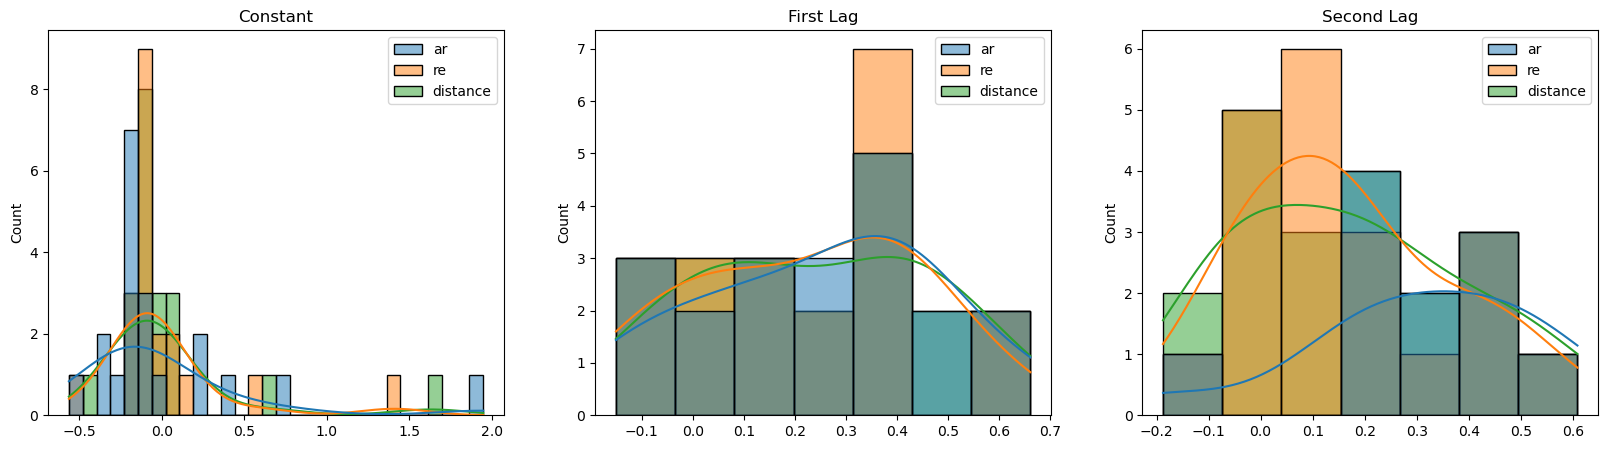

In [55]:
#note that we do not really have enough values for these plots. If we use more countries, or don't take averages of the parameters, it might show a clearer image


import seaborn as sns
import matplotlib.pyplot as plt
frame_use = params.reset_index()
const_frame = frame_use[frame_use["level_1"] == "const"]
L1_frame = frame_use[frame_use["level_1"] == "L1"]
L2_frame = frame_use[frame_use["level_1"] == "L2"]

figures, axis = plt.subplots(1,3,figsize=(20,5))
axis[0].set_title("Constant")
axis[1].set_title("First Lag")
axis[2].set_title("Second Lag")

sns.histplot(
    data = const_frame,
    kde=True,
    ax= axis[0],
)

sns.histplot(
    data=L1_frame,
    kde=True,
    ax= axis[1]
)

sns.histplot(
    data=L2_frame,
    kde=True,
    ax= axis[2]
)


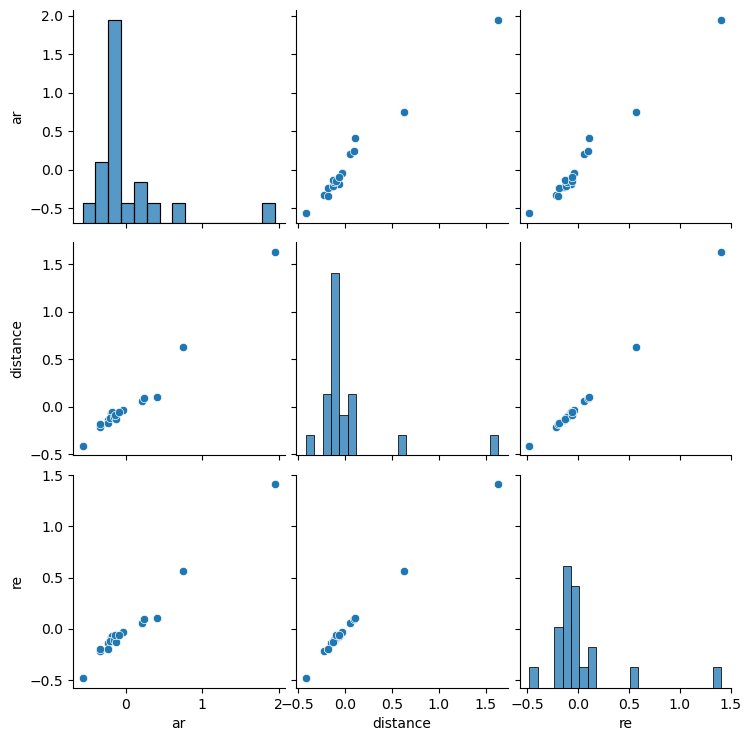

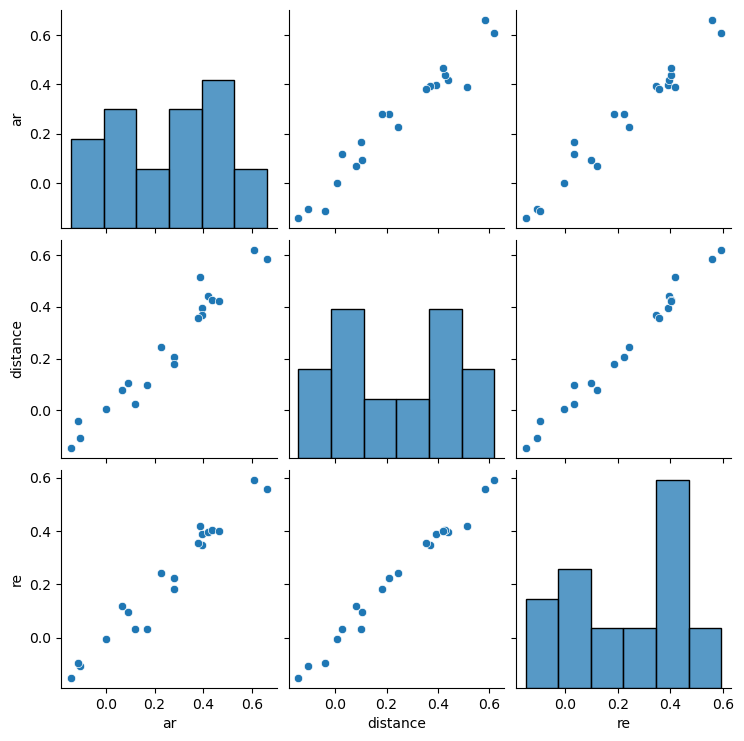

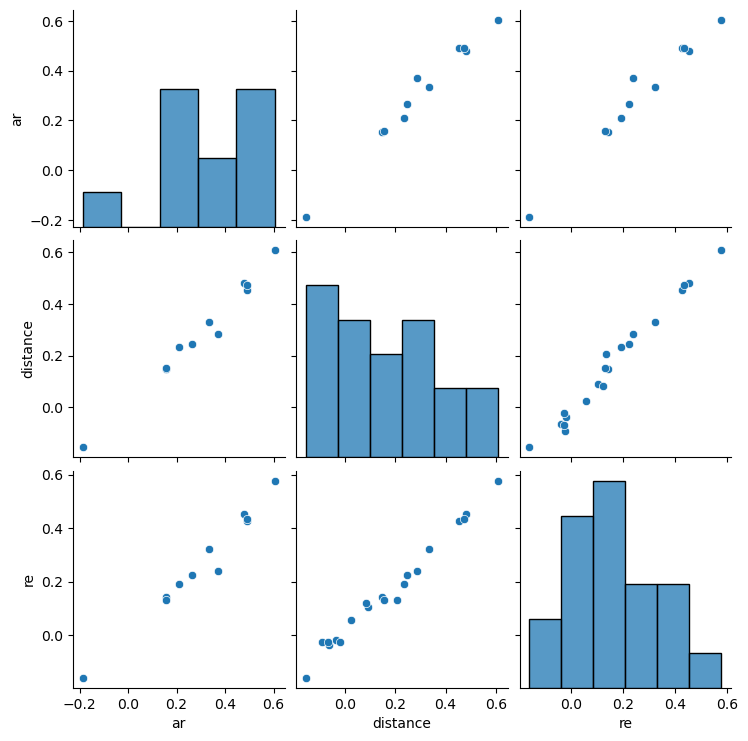

In [41]:
#note that mostly the ar constants are different from the other two models. 
#The lagged coefficients are very similar along models

from mpl_toolkits.mplot3d import Axes3D
sns.pairplot(const_frame[['ar','distance', 're']])
sns.pairplot(L1_frame[['ar','distance', 're']])
sns.pairplot(L2_frame[['ar','distance', 're']])

# Compare forecasts

pred_ar   pred_re  pred_distance
date       country                                         
2010-01-01 Japan         -0.000515  0.001700       0.001595
           Canada         0.004424  0.004175       0.004028
           United States  0.004773  0.007540       0.007465
           Australia      0.008211  0.007982       0.007958
           New Zealand    0.004259  0.008459       0.008602
...                            ...       ...            ...
2023-01-01 Norway         0.005844  0.005269       0.005497
           Belgium        0.017457  0.014160       0.013958
           Korea          0.006778  0.008639       0.009013
           South Africa   0.012069  0.015210       0.015016
2021-01-01 Türkiye        0.025698  0.023908       0.024260

[1060 rows x 3 columns]

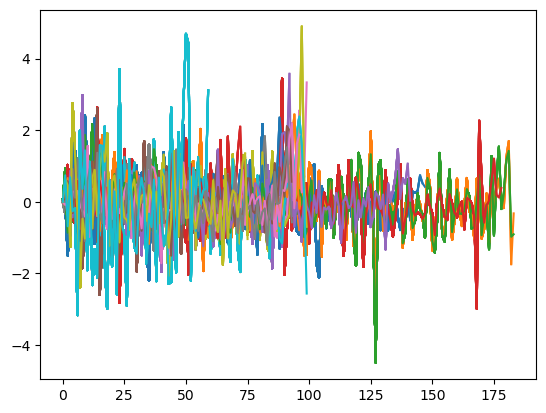

In [42]:
from seminartools.models.utils import h_period_ahead_forecast

preds = pd.concat(
    [
        h_period_ahead_forecast(
            model,
            df,
            h=1,
            start_date="2010-01-01",
        )
        .set_index(["date", "country"])["inflation"].rename(f"pred_{name}")
        #.rename(columns = {"inflation": f"pred_{name}"})
        for model, name in [
            (model_ar, "ar"),
            (model_re, "re"),
            (model_distance, "distance"),
        ]
    ], axis=1
)
preds

In [43]:
merged = preds.merge(df[["inflation", "date", "country"]], left_index=True, right_on = ["date", "country"]).set_index(["date", "country"]).dropna()
merged

pred_ar   pred_re  pred_distance  inflation
date       country                                                    
2010-01-01 Japan         -0.000515  0.001700       0.001595   0.000000
           Canada         0.004424  0.004175       0.004028   0.004405
           United States  0.004773  0.007540       0.007465   0.004014
           Australia      0.008211  0.007982       0.007958   0.009132
           New Zealand    0.004259  0.008459       0.008602   0.003659
...                            ...       ...            ...        ...
2023-01-01 Netherlands    0.002615  0.016561       0.017524  -0.013667
           Norway         0.005844  0.005269       0.005497   0.006886
           Belgium        0.017457  0.014160       0.013958  -0.003628
           Korea          0.006778  0.008639       0.009013   0.010538
           South Africa   0.012069  0.015210       0.015016   0.011202

[1016 rows x 4 columns]

In [44]:
from sklearn.metrics import mean_squared_error

for col in ["pred_ar", "pred_re", "pred_distance"]:
    print(f"{col}: {mean_squared_error(merged['inflation'], merged[col]):.2g}")

pred_ar: 4.9e-05
pred_re: 7.5e-05
pred_distance: 7.6e-05
